# Intel Image Classification using GRU Model

### 1. Introduction
In this notebook, we use a GRU-based deep learning model to classify images of **buildings** and **streets** from the Intel Image Classification dataset. This model combines CNN-based feature extraction (ResNet50) with an RNN GRU layer to capture spatial dependencies in the extracted features.


In [2]:
import os, pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
print("✅ TensorFlow version:", tf.__version__)
print("All imports work!")

✅ TensorFlow version: 2.10.0
All imports work!


### 2. Dataset Preparation
We selected two classes — **buildings** and **streets** — from the Intel Image Classification dataset available on Kaggle.
The dataset is divided into training, validation, and test sets. Each image is resized to 150×150 pixels and batched with a size of 32.


In [3]:
BASE_DIR = os.getcwd()
TRAIN_DIR = os.path.join(BASE_DIR, "data", "train")
TEST_DIR  = os.path.join(BASE_DIR, "data", "test")

CLASS_ORDER = ['buildings', 'street']   # ensures consistency


In [4]:
IMG_SIZE   = (150, 150)
BATCH_SIZE = 32
SEED       = 42
EPOCHS     = 10


In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    label_mode="binary",
    class_names=CLASS_ORDER
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    label_mode="binary",
    class_names=CLASS_ORDER
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    class_names=CLASS_ORDER
)


Found 4573 files belonging to 2 classes.
Using 3659 files for training.
Found 4573 files belonging to 2 classes.
Using 914 files for validation.
Found 938 files belonging to 2 classes.


In [6]:
train_count = tf.data.experimental.cardinality(train_ds).numpy() * BATCH_SIZE
val_count = tf.data.experimental.cardinality(val_ds).numpy() * BATCH_SIZE
test_count = tf.data.experimental.cardinality(test_ds).numpy() * BATCH_SIZE

print(f"Training images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Test images: {test_count}")


Training images: 3680
Validation images: 928
Test images: 960


### 3. Sample Images from Dataset
Below are some randomly selected images from the dataset for each class. 


In [9]:
AUTOTUNE = tf.data.AUTOTUNE
def preprocess(ds):
    return (ds
            .map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
            .cache()
            .prefetch(AUTOTUNE))

train_ds = preprocess(train_ds)
val_ds   = preprocess(val_ds)
test_ds  = preprocess(test_ds)


### 4. Model Architecture
I use the pre-trained **ResNet50** model (trained on ImageNet) as a feature extractor. The convolutional layers are frozen to retain learned spatial representations.
The extracted feature maps are reshaped into sequences and passed into a **GRU layer** (128 units) to capture sequential dependencies.
Finally, a dense layer with sigmoid activation performs binary classification.



In [11]:
cnn_base = ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
cnn_base.trainable = False  # freeze CNN first

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = preprocess_input(inputs)
x = cnn_base(x, training=False)
x = layers.AveragePooling2D(pool_size=(2,2))(x)
x = layers.Reshape((-1, x.shape[-1]))(x)
x = layers.GRU(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_gru = models.Model(inputs, outputs)
model_gru.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model_gru.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 150, 150, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 average_pooling2d (AverageP  (None, 2, 2, 2048)       0         
 ooling2D)                                                       
                                                                 
 reshape (Reshape)           (None, 4, 2048)           0     

GRU is computationally efficient compared to LSTM while maintaining the ability to learn long-term dependencies.

### 5. Model Training
The GRU model is trained for 10 epochs using the **Adam optimizer** and **binary cross-entropy loss**.
I monitor both training and validation accuracy to detect overfitting.


In [12]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [13]:
history = model_gru.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stop])


Epoch 1/10
115/115 [==============================] - 218s 2s/step - loss: 0.2906 - accuracy: 0.8838 - val_loss: 0.1961 - val_accuracy: 0.9256
Epoch 2/10
115/115 [==============================] - 130s 1s/step - loss: 0.2231 - accuracy: 0.9139 - val_loss: 0.2038 - val_accuracy: 0.9212
Epoch 3/10
115/115 [==============================] - 135s 1s/step - loss: 0.2105 - accuracy: 0.9224 - val_loss: 0.1929 - val_accuracy: 0.9267
Epoch 4/10
115/115 [==============================] - 155s 1s/step - loss: 0.1973 - accuracy: 0.9216 - val_loss: 0.1884 - val_accuracy: 0.9289
Epoch 5/10
115/115 [==============================] - 174s 2s/step - loss: 0.1744 - accuracy: 0.9339 - val_loss: 0.1895 - val_accuracy: 0.9289
Epoch 6/10
115/115 [==============================] - 158s 1s/step - loss: 0.1770 - accuracy: 0.9333 - val_loss: 0.1963 - val_accuracy: 0.9289
Epoch 7/10
115/115 [==============================] - 131s 1s/step - loss: 0.1513 - accuracy: 0.9453 - val_loss: 0.1768 - val_accuracy: 0.9300

### 6. Performance Visualization
The training and validation accuracy/loss curves are shown below to visualize the model's learning process.


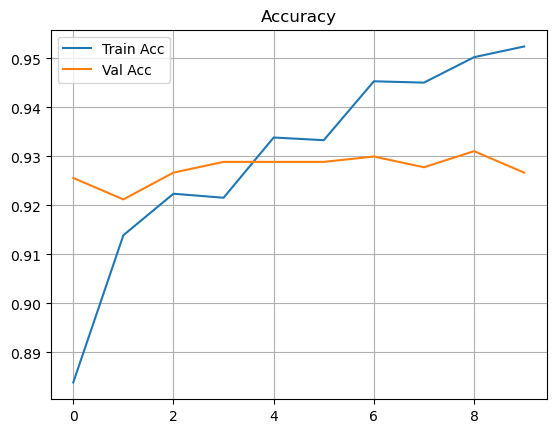

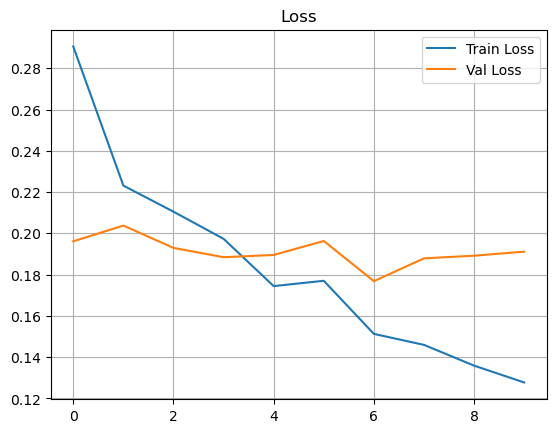

In [14]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy'); plt.legend(); plt.grid(True); plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss'); plt.legend(); plt.grid(True); plt.show()


### 7. Model Evaluation on Test Data
The model is evaluated on unseen test data to measure generalization performance. I calculate the classification report and confusion matrix.


In [15]:
test_loss, test_acc = model_gru.evaluate(test_ds)
print(f" Test Accuracy: {test_acc:.4f}")


30/30 [==============================] - 41s 1s/step - loss: 0.1981 - accuracy: 0.9158
 Test Accuracy: 0.9158


In [16]:
y_true, y_pred = [], []
for xb, yb in test_ds:
    probs = model_gru.predict(xb).reshape(-1)
    preds = (probs > 0.5).astype("int32")   # >0.5 -> street
    y_true.extend(yb.numpy())
    y_pred.extend(preds)

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_ORDER))



1/1 [==============================] - 6s 6s/step

 Classification Report:
              precision    recall  f1-score   support

   buildings       0.93      0.88      0.91       437
      street       0.90      0.95      0.92       501

    accuracy                           0.92       938
   macro avg       0.92      0.91      0.92       938
weighted avg       0.92      0.92      0.92       938



### 8. Confusion Matrix
The confusion matrix below shows the number of correctly and incorrectly classified samples for each class.


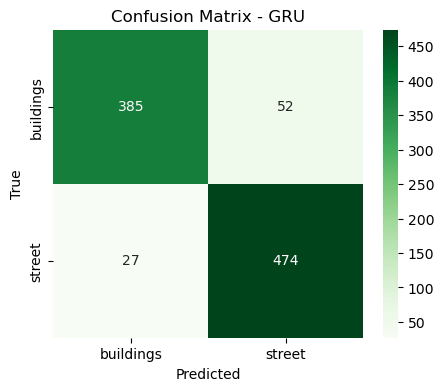

In [17]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=CLASS_ORDER, yticklabels=CLASS_ORDER)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix - GRU"); plt.show()


### 9. Model Saving


In [18]:
model_gru.save("gru_buildings_street.keras")
print("Model saved!")

Model saved!


In [19]:
from tensorflow.keras.preprocessing import image as kimage

def predict_image(img_path):
    img = kimage.load_img(img_path, target_size=IMG_SIZE)
    arr = kimage.img_to_array(img)[None, ...]
    arr = preprocess_input(arr)
    prob = model_gru.predict(arr)[0][0]
    label = CLASS_ORDER[1] if prob > 0.5 else CLASS_ORDER[0]
    plt.imshow(img); plt.axis("off")
    plt.title(f"Predicted: {label} (p(street)={prob:.2f})")
    plt.show()
    return label, prob


## 10. Discussion and Future Work 

The GRU model achieved promising results in classifying images between **buildings** and **streets**.  
While the accuracy is satisfactory, further improvements can be made by:

- Increasing training epochs or using fine-tuning of the CNN base (unfreezing top layers).  
- Using a hybrid **CNN + GRU** model for feature enhancement.  
- Applying more aggressive data augmentation.  
- Experimenting with **LSTM** or **CNN-only models** for comparison.

### Future Work
In the future, this approach can be extended to all six classes in the Intel dataset to evaluate scalability and model generalization.
